In [ ]:
!python -m pip install -U pip
!python -m pip install -U matplotlib

     |████████████████████████████████| 1.6MB 5.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 10.3 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Run ALL

## Imports

In [ ]:
import matplotlib

In [ ]:
matplotlib.__version__

'3.4.2'

In [ ]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from google.colab.patches import cv2_imshow

## Read image and plot 2Dbb

In [ ]:
# Read 2 images of vehicles
img1 = cv2.imread('test_img2.png')

In [ ]:
# Shape of img1
img1.shape

(135, 133, 3)

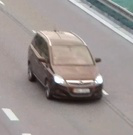

In [ ]:
# Display img1
cv2_imshow(img1)

In [ ]:
# 2D bounding box coordinates for both images
img1_2dbb = np.array([30,30,73, 75])

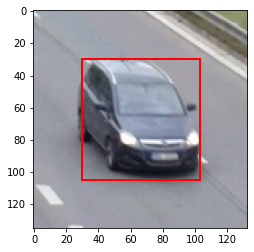

In [ ]:
# Plot 2D bounding box on image 1
fig, ax = plt.subplots()
ax.imshow(img1)
rect = patches.Rectangle((img1_2dbb[0],img1_2dbb[1]), img1_2dbb[2], img1_2dbb[3], linewidth = 2, edgecolor = 'red', facecolor = 'none')
ax.add_patch(rect)
plt.show()

In [ ]:
# Vanishing points of image 1
# vp11 = [53.6673, 7.88592]
vp11 = [-285.74607214, -242.64758361]
vp21 = [18039.4, 114.174]
vp31 = [259.38534916, 28688.32945509]
pp1 = [427.5, 240.5]


In [ ]:
# Function to get vertices of 2Dbb
def convert_to_vertices(bbox):
   x = bbox[0]
   y = bbox[1]
   w = bbox[2]
   h = bbox[3] 
   pts = [[x,y],[w+x,x],[w+x,h+y],[x,h+y]]
   return pts

In [ ]:
# Get vertices of 2Dbb of img1
pts1 = convert_to_vertices(img1_2dbb)
pts1

[[30, 30], [103, 30], [103, 105], [30, 105]]

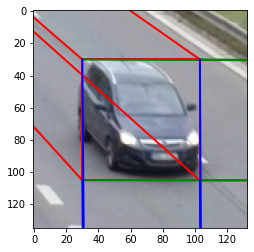

In [ ]:
# Plot Vanishing Points lines connected to 2Dbb on img1

fig, ax = plt.subplots()

ax.plot([pts1[0][0],vp11[0]],[ pts1[0][1], vp11[1]], color = 'red',linewidth = 2)
ax.plot([pts1[1][0],vp11[0]],[ pts1[1][1], vp11[1]], color = 'red',linewidth = 2)
ax.plot([pts1[2][0],vp11[0]],[ pts1[2][1], vp11[1]], color = 'red',linewidth = 2)
ax.plot([pts1[3][0],vp11[0]],[ pts1[3][1], vp11[1]], color = 'red',linewidth = 2)

ax.plot([pts1[0][0],vp21[0]],[ pts1[0][1], vp21[1]], color = 'green',linewidth = 2)
ax.plot([pts1[1][0],vp21[0]],[ pts1[1][1], vp21[1]], color = 'green',linewidth = 2)
ax.plot([pts1[2][0],vp21[0]],[ pts1[2][1], vp21[1]], color = 'green',linewidth = 2)
ax.plot([pts1[3][0],vp21[0]],[ pts1[3][1], vp21[1]], color = 'green',linewidth = 2)

ax.plot([pts1[0][0],vp31[0]],[ pts1[0][1], vp31[1]], color = 'blue',linewidth = 2)
ax.plot([pts1[1][0],vp31[0]],[ pts1[1][1], vp31[1]], color = 'blue',linewidth = 2)
ax.plot([pts1[2][0],vp31[0]],[ pts1[2][1], vp31[1]], color = 'blue',linewidth = 2)
ax.plot([pts1[3][0],vp31[0]],[ pts1[3][1], vp31[1]], color = 'blue',linewidth = 2)

ax.plot([vp11[0],vp21[0]],[ vp11[1], vp21[1]], color = 'yellow',linewidth = 3)

ax.imshow(img1)
rect = patches.Rectangle((img1_2dbb[0],img1_2dbb[1]), img1_2dbb[2], img1_2dbb[3], linewidth = 2, edgecolor = 'red', facecolor = 'none')
ax.add_patch(rect)
plt.show()



In [ ]:
# Get masks for both the images
mask1 = cv2.imread('img2_mask.png')


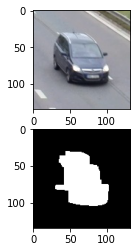

In [ ]:
# Display both Images and masks
fig, ax = plt.subplots(2,1)
ax[0].imshow(img1)
ax[1].imshow(mask1)
plt.show()

In [ ]:
# Either use Vp1-Vp2 or Vp2-Vp3 pair for transformation
pair1 = '12'
pair2 = '23'

## Contours (img1)

In [ ]:
def is_right(l1, l2, p):
    return ((p[0] - l1[0]) * (l2[1] - l1[1]) - (p[1] - l1[1]) * (l2[0] - l1[0])) < 0

def find_cornerpts(VP, pts):
    pts = np.array(pts)
    for P1 in range(len(pts)):
        bad = False
        for idx in range(len(pts)):
            if (pts[idx] != pts[P1]).any() and is_right(VP, pts[P1], pts[idx]):
                bad = True
                break
        if not bad:
            break

    for P2 in range(len(pts)):
        bad = False
        for idx in range(len(pts)):
            if (pts[idx] != pts[P2]).any() and not is_right(VP, pts[P2], pts[idx]):
                bad = True
                break
        if not bad:
            break

    return P1, P2

def get_pts_from_mask(mask, vp1, vp2):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask,127, 255, 0)
    # _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    countours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    hull = cv2.convexHull(countours[0])
    pts = hull[:, 0, :]
    idx1, idx2 = find_cornerpts(vp1, pts)
    idx3, idx4 = find_cornerpts(vp2, pts)
    pts = pts[[idx1, idx2, idx3, idx4]]

    return [pts[0], pts[1], pts[2], pts[3]]

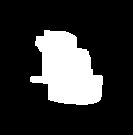

In [ ]:
# Get binary image of mask
mask1_gray = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
_, mask1_img = cv2.threshold(mask1_gray,127, 255, 0)
cv2_imshow(mask1_img)

In [ ]:
# Find contours
contour1, _ = cv2.findContours(mask1_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

In [ ]:
# Number of contour points
len(contour1[0])

80

In [ ]:
# Shape of contour points
contour1[0].shape

(80, 1, 2)

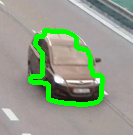

In [ ]:
# Image with Contours drawn on it
img_contour1 = cv2.drawContours(img1, contour1, -1, (0,255,0), 3)
cv2_imshow(img_contour1)

In [ ]:
# Convex hull
hull_1 = cv2.convexHull(contour1[0])

In [ ]:
# Shape of hull
hull_1.shape

(24, 1, 2)

In [ ]:
# Get points from hull
hull_pts1 = hull_1[:,0,:]

In [ ]:
# Print the pts from hull
print(len(hull_pts1))
hull_pts1

24


array([[102,  84],
       [101,  96],
       [100,  99],
       [ 98, 101],
       [ 96, 102],
       [ 93, 103],
       [ 87, 104],
       [ 76, 104],
       [ 64, 103],
       [ 58, 102],
       [ 50, 100],
       [ 48,  99],
       [ 30,  81],
       [ 30,  77],
       [ 35,  41],
       [ 36,  36],
       [ 44,  30],
       [ 49,  30],
       [ 65,  31],
       [ 68,  32],
       [ 74,  35],
       [ 76,  37],
       [ 88,  51],
       [102,  76]], dtype=int32)

In [ ]:
hull_pts1[0]

array([102,  84], dtype=int32)

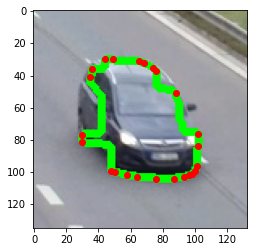

In [ ]:
# Plot hull points on img1
fig, ax = plt.subplots()
for i in range(len(hull_pts1)):
  ax.plot(hull_pts1[i][0],hull_pts1[i][1],'ro')
ax.imshow(img1)
plt.show()

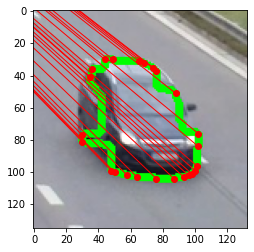

In [ ]:
# Connect hull points to 1st VP
fig, ax = plt.subplots()
for i in range(len(hull_pts1)):
  ax.plot(hull_pts1[i][0],hull_pts1[i][1],'ro')
for i in range(len(hull_pts1)):
  ax.plot([hull_pts1[i][0], vp11[0]],[hull_pts1[i][1],vp11[1]], color = 'red', linewidth = 1)
ax.imshow(img1)

plt.show()

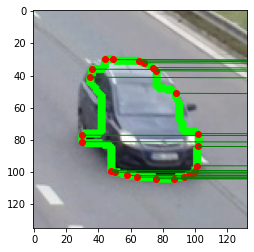

In [ ]:
# Connect hull points to 2nd VP
fig, ax = plt.subplots()
for i in range(len(hull_pts1)):
  ax.plot(hull_pts1[i][0],hull_pts1[i][1],'ro')
for i in range(len(hull_pts1)):
  ax.plot([hull_pts1[i][0], vp21[0]],[hull_pts1[i][1],vp21[1]], color = 'green', linewidth = 1)
ax.imshow(img1)

plt.show()

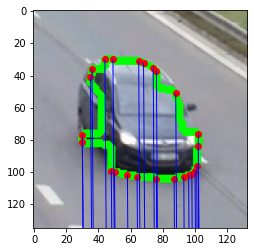

In [ ]:
# Connect hull points to 3rd VP
fig, ax = plt.subplots()
for i in range(len(hull_pts1)):
  ax.plot(hull_pts1[i][0],hull_pts1[i][1],'ro')
for i in range(len(hull_pts1)):
  ax.plot([hull_pts1[i][0], vp31[0]],[hull_pts1[i][1],vp31[1]], color = 'blue', linewidth = 1)
ax.imshow(img1)

plt.show()

In [ ]:
get_pts_from_mask(mask1, vp11, vp21)

[array([30, 81], dtype=int32),
 array([74, 35], dtype=int32),
 array([49, 30], dtype=int32),
 array([ 76, 104], dtype=int32)]

In [ ]:
pt1, pt2, pt3, pt4 = get_pts_from_mask(mask1, vp11, vp21)

In [ ]:
(pt1[1]-vp11[1])/(pt1[0]-vp11[0])

1.0250248923650789

In [ ]:
(pt2[1]-vp11[1])/(pt2[0]-vp11[0])

0.7717876722277309

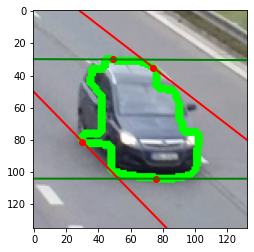

In [ ]:
fig,ax = plt.subplots()
ax.plot(pt1[0], pt1[1],'ro')
ax.plot(pt2[0], pt2[1],'ro')
ax.plot(pt3[0], pt3[1],'ro')
ax.plot(pt4[0], pt4[1],'ro')
ax.axline((pt1[0],pt1[1]),(vp11[0],vp11[1]), color = 'red', linewidth = 2)
ax.axline((pt2[0],pt2[1]),(vp11[0],vp11[1]), color = 'red', linewidth = 2)
ax.axline((pt3[0],pt3[1]),(vp21[0],vp21[1]), color = 'green', linewidth = 2)
ax.axline((pt4[0],pt4[1]),(vp21[0],vp21[1]), color = 'green', linewidth = 2)

ax.imshow(img1)
plt.show()


## my tangents

In [ ]:
# Define function to draw tangents from VP to hull
import math
def tangent_from_vp(vp, pts):
  x1 = vp[0]
  y1 = vp[1]
  slope = []
  
  for i in range(len(pts)):
    x2 = pts[i][0]
    y2 = pts[i][1]
    # print(math.atan2(y2-y1, x2-x1))
    m = math.atan2(y2-y1, x2-x1)
    slope.append(m)
  print(slope)
  print('min slope: ',min(slope))
  print('max slope: ',max(slope))
  
  return pts[slope.index(min(slope))], pts[slope.index(max(slope))]

## Left tangent: Max slope, Right tangent: Min slope

In [ ]:
# Get tangent points for VP1
hull_t11, hull_t21 = tangent_from_vp(vp11, hull_pts1)
print('\nTangent hull points are: ')
print(hull_t11)
print(hull_t21)

[0.7000808180594861, 0.719188342236773, 0.7248469336541161, 0.7303276474147932, 0.7343703451365509, 0.7397386191793975, 0.7491356140679978, 0.7640876918140292, 0.7795044641360429, 0.7867077497759699, 0.795571126149427, 0.7970967497560791, 0.7977553540068595, 0.7915383922184982, 0.7240937442947026, 0.7137373643166093, 0.6908945018844869, 0.6835145288826849, 0.6625426503838647, 0.6601826051581863, 0.6573000237811762, 0.6580902672181865, 0.6659526203199798, 0.6878897058839517]
min slope:  0.6573000237811762
max slope:  0.7977553540068595

Tangent hull points are: 
[74 35]
[30 81]


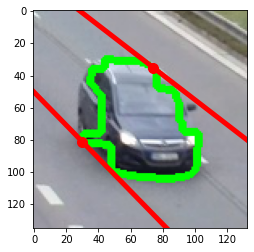

In [ ]:
# Plot tangent to hull from VP1
fig, ax = plt.subplots()

ax.plot(hull_t11[0],hull_t11[1], 'ro', markersize = 10)
ax.plot(hull_t21[0],hull_t21[1], 'ro', markersize = 10)
ax.axline((hull_t11[0], hull_t11[1]),(vp11[0], vp11[1]), color = 'r',linewidth = 5)
ax.axline((hull_t21[0], hull_t21[1]),(vp11[0], vp11[1]), color = 'r',linewidth = 5)
ax.imshow(img1)

plt.show()

In [ ]:
# Get tangent points for VP2
hull_t12, hull_t22 = tangent_from_vp(vp21, hull_pts1)
print('\nTangent hull points are: ')
print(hull_t12)
print(hull_t22)

[-3.139910471582451, -3.1405795201006397, -3.1407468061043025, -3.140858374345568, -3.14091418695961, -3.140970021833226, -3.141025932766349, -3.141026279801305, -3.1409710263347272, -3.140915620759206, -3.1408047453178702, -3.1407492508305803, -3.1397506176264, -3.1395285122411374, -3.13752844722307, -3.137250501068918, -3.1369151590012114, -3.1369138590227963, -3.1369653277066165, -3.137020198059394, -3.137185655279902, -3.137296500010799, -3.138073499696049, -3.1394644776909293]
min slope:  -3.141026279801305
max slope:  -3.1369138590227963

Tangent hull points are: 
[ 76 104]
[49 30]


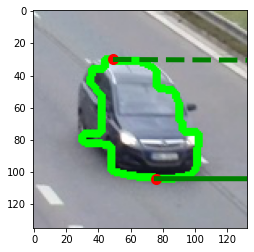

In [ ]:
# Plot tangent to hull from VP1
fig, ax = plt.subplots()

ax.plot(hull_t12[0],hull_t12[1], 'ro', markersize = 10)
ax.plot(hull_t22[0],hull_t22[1], 'ro', markersize = 10)
ax.plot([hull_t12[0],vp21[0]],[ hull_t12[1], vp21[1]], 'g-',linewidth = 5)
ax.plot([hull_t22[0],vp21[0]],[ hull_t22[1], vp21[1]], 'g--',linewidth = 5)
ax.imshow(img1)

plt.show()

In [ ]:
# Get tangent points for VP3
hull_t13, hull_t23 = tangent_from_vp(vp31, hull_pts1)
print('\nTangent hull points are: ')
print(hull_t13)
print(hull_t23)

[-1.576298422595649, -1.5763357050887332, -1.5763712633522269, -1.5764416122350773, -1.57651177096718, -1.5766169163533565, -1.5768270178273631, -1.5772118291587178, -1.5776313820559476, -1.5778410233877709, -1.5781203505918464, -1.5781900468028103, -1.578814566791918, -1.5788134458518495, -1.5786288460855824, -1.5785925802753626, -1.5783118134987426, -1.5781373537799643, -1.5775793164066934, -1.5774748689299833, -1.5772661774544359, -1.5771968271705519, -1.5767809387097518, -1.5762968842421043]
min slope:  -1.578814566791918
max slope:  -1.5762968842421043

Tangent hull points are: 
[30 81]
[102  76]


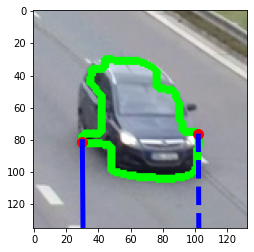

In [ ]:
# Plot tangent to hull from VP3
fig, ax = plt.subplots()

ax.plot(hull_t13[0],hull_t13[1], 'ro', markersize = 10)
ax.plot(hull_t23[0],hull_t23[1], 'ro', markersize = 10)
ax.plot([hull_t13[0],vp31[0]],[ hull_t13[1], vp31[1]], 'b-',linewidth = 5)
ax.plot([hull_t23[0],vp31[0]],[ hull_t23[1], vp31[1]], 'b--',linewidth = 5)
ax.imshow(img1)

plt.show()

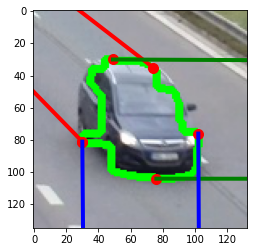

In [ ]:
# final img1 with tangents from 3Vps to hull 
fig, ax = plt.subplots()

ax.plot(hull_t11[0],hull_t11[1], 'ro', markersize = 10)
ax.plot(hull_t21[0],hull_t21[1], 'ro', markersize = 10)
ax.plot([hull_t11[0],vp11[0]],[ hull_t11[1], vp11[1]], color = 'red',linewidth = 4)
ax.plot([hull_t21[0],vp11[0]],[ hull_t21[1], vp11[1]], color = 'red',linewidth = 4)

ax.plot(hull_t12[0],hull_t12[1], 'ro', markersize = 10)
ax.plot(hull_t22[0],hull_t22[1], 'ro', markersize = 10)
ax.plot([hull_t12[0],vp21[0]],[ hull_t12[1], vp21[1]], color = 'green',linewidth = 4)
ax.plot([hull_t22[0],vp21[0]],[ hull_t22[1], vp21[1]], color = 'green',linewidth = 4)

ax.plot(hull_t13[0],hull_t13[1], 'ro', markersize = 10)
ax.plot(hull_t23[0],hull_t23[1], 'ro', markersize = 10)
ax.plot([hull_t13[0],vp31[0]],[ hull_t13[1], vp31[1]], color = 'blue',linewidth = 4)
ax.plot([hull_t23[0],vp31[0]],[ hull_t23[1], vp31[1]], color = 'blue',linewidth = 4)
ax.imshow(img1)
plt.savefig('new_img1.png')
plt.show()


In [ ]:
# Save this image with tangents from Vp to hull
new_img1 = cv2.imread('new_img1.png')

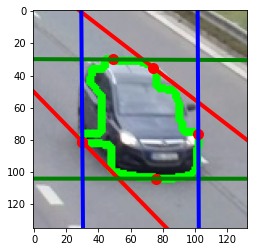

In [ ]:
# final img1 with tangents from 3Vps to hull (Extended) 
fig, ax = plt.subplots()

## tangents from vp1 (RED)
ax.plot(hull_t11[0],hull_t11[1], 'ro', markersize = 10)
ax.plot(hull_t21[0],hull_t21[1], 'ro', markersize = 10)
ax.axline((hull_t11[0],hull_t11[1]), (vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t21[0],hull_t21[1]), (vp11[0], vp11[1]), color = 'red',linewidth = 4)

## tangents from vp2 (GREEN)
ax.plot(hull_t12[0],hull_t12[1], 'ro', markersize = 10)
ax.plot(hull_t22[0],hull_t22[1], 'ro', markersize = 10)
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t22[0],hull_t22[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)

## tangents from vp3 (BLUE)
ax.plot(hull_t13[0],hull_t13[1], 'ro', markersize = 10)
ax.plot(hull_t23[0],hull_t23[1], 'ro', markersize = 10)
ax.axline((hull_t13[0], hull_t13[1]), (vp31[0],vp31[1]), color = 'blue',linewidth = 4)
ax.axline((hull_t23[0], hull_t23[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.imshow(img1)

plt.show()

In [ ]:
# Define function to plot tangents for different pairs of VPs
def plot_img_tangent(pair):
  fig, ax = plt.subplots()
  if pair == '12':
    ax.plot(hull_t11[0],hull_t11[1], 'ro', markersize = 10)
    ax.plot(hull_t21[0],hull_t21[1], 'ro', markersize = 10)
    ax.plot([hull_t11[0],vp11[0]],[ hull_t11[1], vp11[1]], color = 'red',linewidth = 2)
    ax.plot([hull_t21[0],vp11[0]],[ hull_t21[1], vp11[1]], color = 'red',linewidth = 2)

    ax.plot(hull_t12[0],hull_t12[1], 'ro', markersize = 10)
    ax.plot(hull_t22[0],hull_t22[1], 'ro', markersize = 10)
    ax.plot([hull_t12[0],vp21[0]],[ hull_t12[1], vp21[1]], color = 'blue',linewidth = 2)
    ax.plot([hull_t22[0],vp21[0]],[ hull_t22[1], vp21[1]], color = 'blue',linewidth = 2)
  
  elif pair == '23':
    ax.plot(hull_t12[0],hull_t12[1], 'ro', markersize = 10)
    ax.plot(hull_t22[0],hull_t22[1], 'ro', markersize = 10)
    ax.plot([hull_t12[0],vp21[0]],[ hull_t12[1], vp21[1]], color = 'blue',linewidth = 2)
    ax.plot([hull_t22[0],vp21[0]],[ hull_t22[1], vp21[1]], color = 'blue',linewidth = 2)

    ax.plot(hull_t13[0],hull_t13[1], 'ro', markersize = 10)
    ax.plot(hull_t23[0],hull_t23[1], 'ro', markersize = 10)
    ax.plot([hull_t13[0],vp31[0]],[ hull_t13[1], vp31[1]], color = 'green',linewidth = 2)
    ax.plot([hull_t23[0],vp31[0]],[ hull_t23[1], vp31[1]], color = 'green',linewidth = 2)

  ax.imshow(img1)
  plt.show()


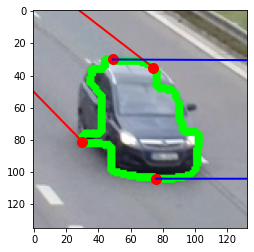

In [ ]:
# Plot tangents from Vp1 & Vp2
plot_img_tangent(pair1)

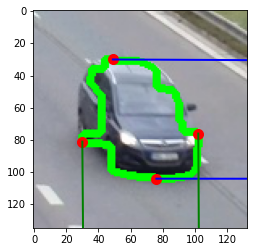

In [ ]:
# Plot tangents from Vp2 & Vp3
plot_img_tangent(pair2)

## 3dbb (img1)

In [ ]:
# Define functions to get coordinates of line and intersection points
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

def intersection(L1, L2):
    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return np.float32(x), np.float32(y)
    else:
        return False

In [ ]:
# Equation of tangent lines
## Vp1
L11 = []
L21 = []
L11 = line(hull_t11, vp11) # left
L21 = line(hull_t21, vp11) # right


# Vp2
L12 = []
L22 = []
L12 = line(hull_t12, vp21) # left
L22 = line(hull_t22, vp21) # right

# Vp3
L13 = []
L23 = []
L13 = line(hull_t13, vp31) # left
L23 = line(hull_t23, vp31) # right

In [ ]:
# pt A = R1 + L2
## lines are L21 & L12
A = intersection(L21, L12)

In [ ]:
# pt B = L2 + R3
## lines are L12 & L23
B = intersection(L12, L23)

In [ ]:
# pt C = R1 + L3
## lines are L21 & L13
C = intersection(L21, L13)

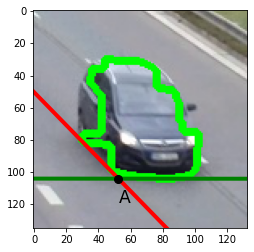

In [ ]:
# Plot pt A (pt A = R1 + L2; lines L21 & L12)
fig, ax = plt.subplots()

ax.axline((hull_t21[0],hull_t21[1]),(vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.plot(A[0], A[1], 'ko', markersize = 8)
ax.text(A[0],A[1] + 15, 'A', fontsize = 'xx-large', color = 'k')

ax.imshow(img1)
plt.show()


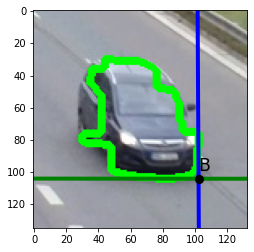

In [ ]:
# Plot pt B (pt B = L2 + R3; lines L12 & L23)
fig, ax = plt.subplots()

ax.axline((hull_t12[0],hull_t12[1]), (vp21[0],vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t23[0],hull_t23[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(B[0], B[1], 'ko', markersize = 8)
ax.text(B[0],B[1] - 5, 'B', fontsize = 'xx-large', color = 'k')

ax.imshow(img1)
plt.show()

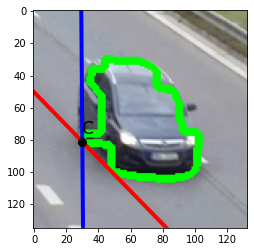

In [ ]:
# Plot pt C (pt C = R1 + L3; lines L21 & L13)
fig, ax = plt.subplots()

ax.axline((hull_t21[0], hull_t21[1]),(vp11[0],vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t13[0], hull_t13[1]), (vp31[0],vp31[1]), color = 'blue',linewidth = 4)
ax.plot(C[0], C[1], 'ko', markersize = 8)
ax.text(C[0],C[1] - 5, 'C', fontsize = 'xx-large', color = 'k')

ax.imshow(img1)
plt.show()


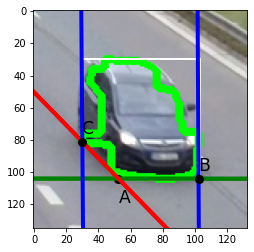

In [ ]:
# Step 1: plot A, B , C 
fig, ax = plt.subplots()

## pt A
ax.axline((hull_t21[0],hull_t21[1]),(vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.plot(A[0], A[1], 'ko', markersize = 8)
ax.text(A[0],A[1] + 15, 'A', fontsize = 'xx-large', color = 'k')

## pt B
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0],vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t23[0],hull_t23[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(B[0], B[1], 'ko', markersize = 8)
ax.text(B[0],B[1] - 5, 'B', fontsize = 'xx-large', color = 'k')

## pt C
ax.axline((hull_t21[0], hull_t21[1]),(vp11[0],vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t13[0], hull_t13[1]), (vp31[0],vp31[1]), color = 'blue',linewidth = 4)
ax.plot(C[0], C[1], 'ko', markersize = 8)
ax.text(C[0],C[1] - 5, 'C', fontsize = 'xx-large', color = 'k')

plt.imshow(img1)
rect = patches.Rectangle((img1_2dbb[0],img1_2dbb[1]), img1_2dbb[2], img1_2dbb[3], linewidth = 2, edgecolor = 'white', facecolor = 'none')
ax.add_patch(rect)
plt.show()




In [ ]:
# pt D = R2 + L3
## lines are L22 & L13
D = intersection(L22, L13)

In [ ]:
# pt F = L1 + R3
## lines are L11 & L23
F = intersection(L11, L23)

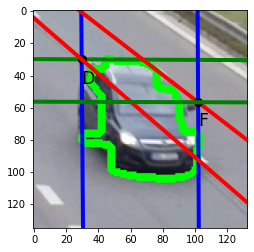

In [ ]:
# Plot pt D, F
fig, ax = plt.subplots()

## pt D
ax.axline((hull_t22[0],hull_t22[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t13[0],hull_t13[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(D[0], D[1], 'ko', markersize = 8)
ax.text(D[0],D[1] + 15, 'D', fontsize = 'xx-large', color = 'k')

## pt F
ax.axline((hull_t11[0],hull_t11[1]), (vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t23[0], hull_t23[1]),(vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(F[0], F[1], 'ko', markersize = 8)
ax.text(F[0],F[1] + 15, 'F', fontsize = 'xx-large', color = 'k')

# Draw red line from vp1 to ptD
ax.axline((vp11[0],vp11[1]), (D[0],D[1]), color = 'red', linewidth = 4)
# Draw green line from vp2 to ptF
ax.axline((vp21[0],vp21[1]), (F[0],F[1]), color = 'green', linewidth = 4)

ax.imshow(img1)
plt.show()


In [ ]:
# Additional lines 
red_line3 = line(vp11, D)
green_line3 = line(vp21, F)
blue_line3 = line(vp31, A)

In [ ]:
# pt E_D = intersection of 3rd red line and 3rd blue line
E_D = intersection(red_line3, blue_line3)

In [ ]:
E_D

(52.029533, 49.304207)

In [ ]:
# pt E_F = intersection of 3rd green line and 3rd blue line
E_F = intersection(green_line3, blue_line3)

In [ ]:
E_F

(52.080673, 56.367306)

In [ ]:
def distance_2pts(p1, p2):
  x1 = p1[0]
  y1 = p1[1]
  x2 = p2[0]
  y2 = p2[1]
  return np.sqrt(((x2 - x1)**2) + ((y2 - y1)**2))

In [ ]:
A_E_D = distance_2pts(A, E_D)
A_E_F = distance_2pts(A, E_F)

In [ ]:
A_E_D

54.6838749908175

In [ ]:
A_E_F

47.620590948738794

In [ ]:
# pt E (conditional)
if A_E_D >= A_E_F:
  E = E_D
else:
  E = E_F

In [ ]:
E_D

(52.029533, 49.304207)

In [ ]:
E_F

(52.080673, 56.367306)

In [ ]:
E = E_F

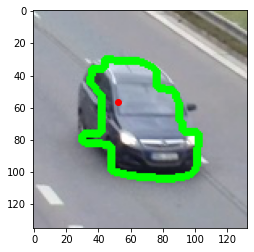

In [ ]:
# Plot pt E
plt.figure()

plt.imshow(img1)
## pt E
plt.plot(E[0], E[1],'ro')


plt.show()

In [ ]:
# pt G = line from vp2 to ptD  + line from vp1 to ptF 
line1_G = line(vp21, D)
line2_G = line(vp11, F)
G = intersection(line1_G, line2_G)

In [ ]:
G

(67.6345, 30.087187)

In [ ]:
# pt H = line from vp2 to ptC  + line from vp1 to ptB
line1_H = line(vp21, C)
line2_H = line(vp11, B)
H = intersection(line1_H, line2_H)

In [ ]:
H

(76.49736, 81.08565)

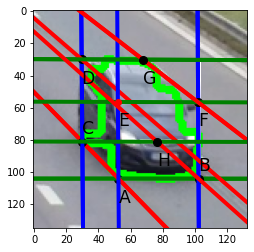

In [ ]:
## FINAL PLOT
fig, ax = plt.subplots()


## pt A
ax.axline((hull_t21[0],hull_t21[1]),(vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.plot(A[0], A[1], 'ko', markersize = 8)
ax.text(A[0],A[1] + 15, 'A', fontsize = 'xx-large', color = 'k')

## pt B
ax.axline((hull_t12[0],hull_t12[1]), (vp21[0],vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t23[0],hull_t23[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(B[0], B[1], 'ko', markersize = 8)
ax.text(B[0],B[1] - 5, 'B', fontsize = 'xx-large', color = 'k')

## pt C
ax.axline((hull_t21[0], hull_t21[1]),(vp11[0],vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t13[0], hull_t13[1]), (vp31[0],vp31[1]), color = 'blue',linewidth = 4)
ax.plot(C[0], C[1], 'ko', markersize = 8)
ax.text(C[0],C[1] - 5, 'C', fontsize = 'xx-large', color = 'k')

## pt D
ax.axline((hull_t22[0],hull_t22[1]), (vp21[0], vp21[1]), color = 'green',linewidth = 4)
ax.axline((hull_t13[0],hull_t13[1]), (vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(D[0], D[1], 'ko', markersize = 8)
ax.text(D[0],D[1] + 15, 'D', fontsize = 'xx-large', color = 'k')

## pt F
ax.axline((hull_t11[0],hull_t11[1]), (vp11[0], vp11[1]), color = 'red',linewidth = 4)
ax.axline((hull_t23[0], hull_t23[1]),(vp31[0], vp31[1]), color = 'blue',linewidth = 4)
ax.plot(F[0], F[1], 'ko', markersize = 8)
ax.text(F[0],F[1] + 15, 'F', fontsize = 'xx-large', color = 'k')

## pt E
# Draw red line from vp1 to ptD
ax.axline((vp11[0],vp11[1]), (D[0],D[1]), color = 'red', linewidth = 4)
# Draw green line from vp2 to ptF
ax.axline((vp21[0],vp21[1]), (F[0],F[1]), color = 'green', linewidth = 4)
# Draw blue line from vp3 to ptA
ax.axline((vp31[0],vp31[1]), (A[0],A[1]), color = 'blue', linewidth = 4)

plt.plot(E[0], E[1],'ro')
ax.text(E[0],E[1] + 15, 'E', fontsize = 'xx-large', color = 'k')

# pt G
# Draw green line from vp2 to ptD
ax.axline((vp21[0],vp21[1]), (D[0],D[1]), color = 'green', linewidth = 4)
# Draw red line from vp1 to ptF
ax.axline((vp11[0],vp11[1]), (F[0],F[1]), color = 'red', linewidth = 4)
plt.plot(G[0], G[1],'ko', markersize = 8)
ax.text(G[0],G[1] + 15, 'G', fontsize = 'xx-large', color = 'k')

# pt H
# Draw green line from vp2 to ptC
ax.axline((vp21[0],vp21[1]), (C[0],C[1]), color = 'green', linewidth = 4)
# Draw red line from vp1 to ptB
ax.axline((vp11[0],vp11[1]), (B[0],B[1]), color = 'red', linewidth = 4)
plt.plot(H[0], H[1],'ko', markersize = 8)
ax.text(H[0],H[1] + 15, 'H', fontsize = 'xx-large', color = 'k')

plt.imshow(img1)
rect = patches.Rectangle((img1_2dbb[0],img1_2dbb[1]), img1_2dbb[2], img1_2dbb[3], linewidth = 2, edgecolor = 'white', facecolor = 'none')
ax.add_patch(rect)
plt.show()


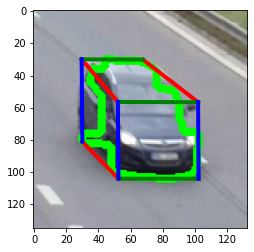

In [ ]:
## 3Dbb

fig, ax = plt.subplots()

## red lines [AC, DE, GF]
ax.plot((A[0],C[0]), (A[1],C[1]),'r-',linewidth = 4)
ax.plot((D[0],E[0]),(D[1],E[1]),'r-',linewidth = 4)
ax.plot((G[0],F[0]),(G[1], F[1]),'r-',linewidth= 4)

## green lines [AB, EF, DG]
ax.plot((A[0], B[0]),(A[1], B[1]),'g-',linewidth= 4)
ax.plot((E[0], F[0]),(E[1], F[1]),'g-',linewidth= 4)
ax.plot((D[0], G[0]),(D[1], G[1]),'g-',linewidth= 4)

## blue lines [CD, EA, FB]
ax.plot((C[0],D[0]),(C[1], D[1]),'b-',linewidth= 4)
ax.plot((E[0], A[0]),(E[1], A[1]),'b-',linewidth= 4)
ax.plot((F[0],B[0]),(F[1], B[1]),'b-',linewidth= 4)

ax.imshow(img1)
plt.show()